In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(int(cfg_model.img_size * 1.5)), 
        Rd.CenterCrop(int(cfg_model.img_size * 1.5)), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 80
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  7840 
test set size:  2027


In [5]:
model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'image_feature_size': cfg_model.image_feature_size,
    'emotion_feature_size': cfg_model.emotion_feature_size,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'loss_weights' : cfg_model.loss_weights,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : True
}
print(model_args)
train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}
print(train_args)

{'cat_dim': 8, 'latent_space_dim': 50, 'image_feature_size': 64, 'emotion_feature_size': 64, 'hidden_dim': 256, 'num_filters': 128, 'loss_weights': {'face': 1.0, 'emotion': 10000.0}, 'expert_type': 'fusion', 'use_cuda': True}
{'learning_rate': 5e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 100, 'batch_size': 32}


In [6]:
model: torch.nn.Module = build_model(**model_args).double()

In [7]:
load_model = False

if load_model:    
    PATH = "../trained_models/moe.save"
    loaded_data = torch.load(PATH)
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    training_losses = loaded_data['training_loss']    
    model.eval()

In [8]:
train_model = True

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        batch_size=cfg_train.batch_size,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train,
        checkpoint_every=cfg_train.checkpoint_every,
        resume_train = False
    )

100%|████████████████████████| 100/100 [2:12:02<00:00, 79.23s/it]


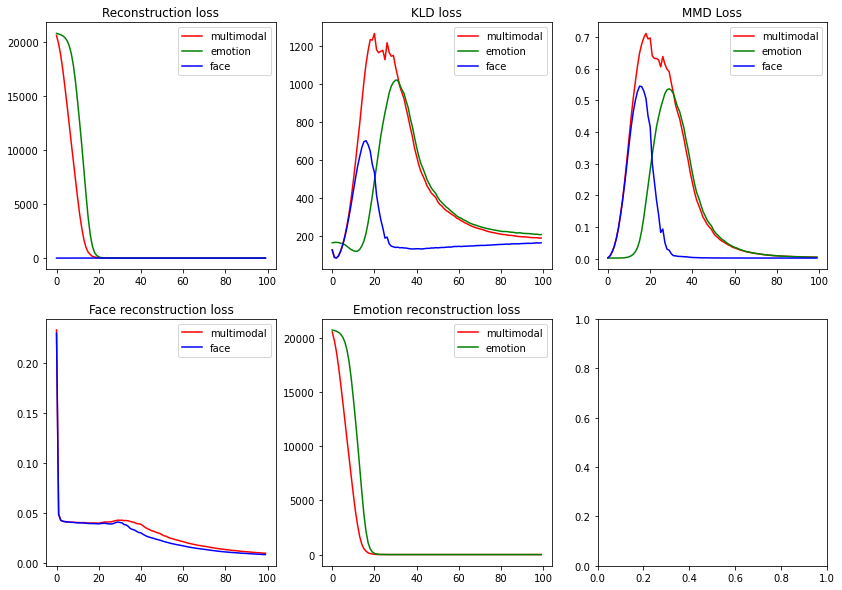

In [9]:
U.print_losses(training_losses)

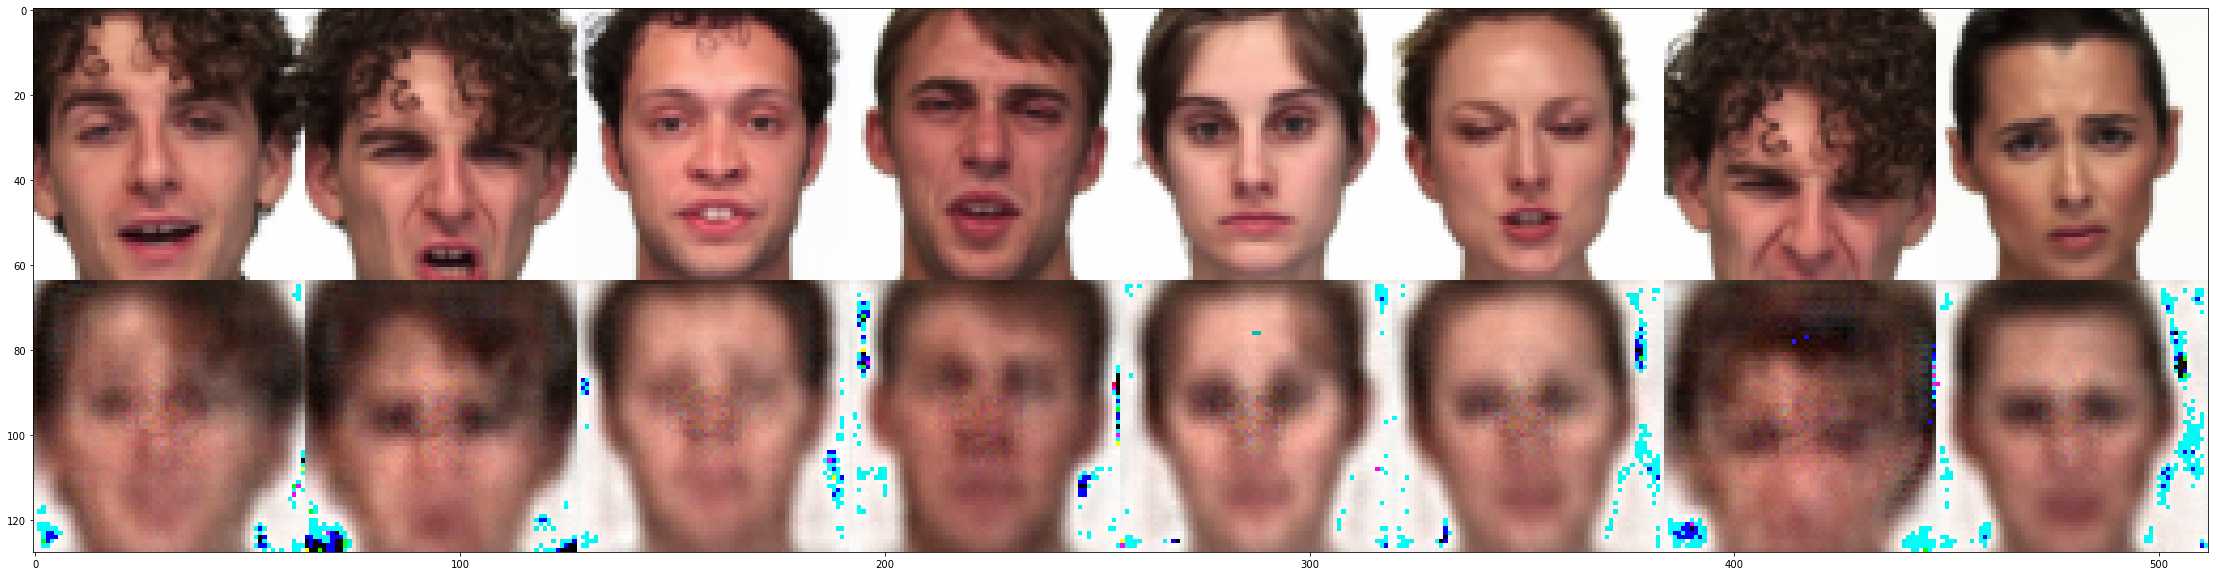

In [10]:
img = U.images_to_images(model, testset_loader, num_images=8, model_eval=True)

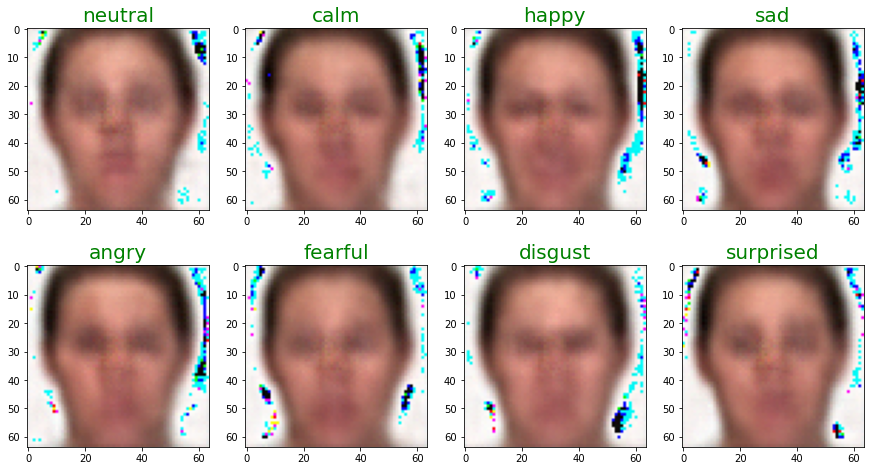

In [11]:
rec_image = U.emotions_to_images(model)

In [12]:
save_model = True

if save_model:
    PATH = "../trained_models/RAVDESS_MVAE_fusion.save"
    torch.save({#'rec_image' : rec_image,
                'model_args' : model_args,
                'training_loss' : training_losses,
                'train_args': train_args,
                'model_params' : model.state_dict()
               }, PATH)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
labels = list(Rd.emocat.values())

100%|████████████████████████| 2048/2048 [01:49<00:00, 18.73it/s]
/home/studenti/ballerini/miniconda3/envs/bll-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/bll-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/bll-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

              precision    recall  f1-score   support

     neutral       0.25      0.99      0.40      4114
        calm       0.00      0.00      0.00      3979
       happy       0.00      0.00      0.00      4109
         sad       0.00      0.00      0.00      4095
       angry       0.00      0.00      0.00      4246
     fearful       0.05      0.06      0.05      4084
     disgust       0.00      0.00      0.00      4062
   surprised       0.36      0.98      0.52      4079

    accuracy                           0.25     32768
   macro avg       0.08      0.25      0.12     32768
weighted avg       0.08      0.25      0.12     32768



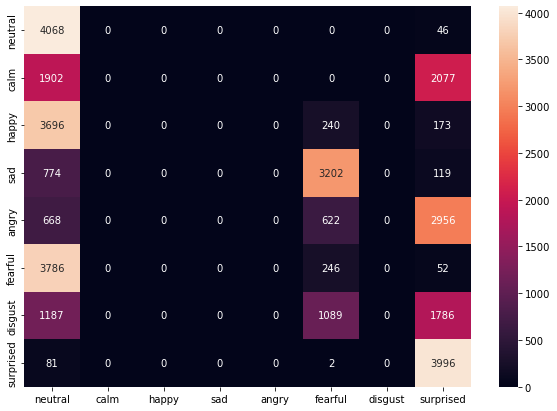

In [14]:
y_true, y_pred = U.recon_and_classiffication_accuracy(model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|████████████████████████████| 64/64 [00:13<00:00,  4.60it/s]


              precision    recall  f1-score   support

     neutral       0.16      0.49      0.24       129
        calm       0.51      0.26      0.35       269
       happy       0.37      0.35      0.36       271
         sad       0.26      0.39      0.31       257
       angry       0.35      0.34      0.35       294
     fearful       0.26      0.22      0.24       263
     disgust       0.60      0.28      0.38       280
   surprised       0.33      0.26      0.29       264

    accuracy                           0.31      2027
   macro avg       0.35      0.32      0.31      2027
weighted avg       0.37      0.31      0.32      2027



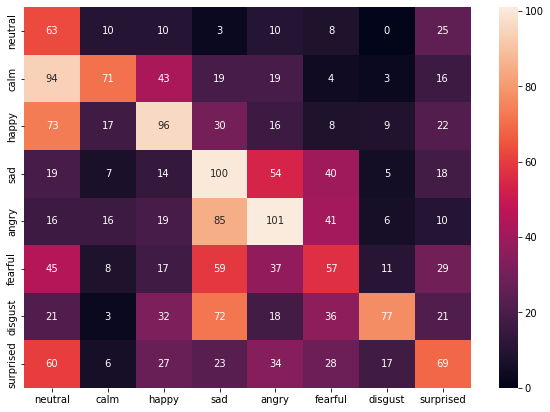

In [15]:
y_true, y_pred = U.classiffication_accuracy(model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)